### Generatee DATA and test LCMGP

- This is to generate the artificial data needed to test the model.
- Basic idea is:
    - Have three kinds of latent processes handy:
        - Cyclic > Cosine Kernel
        - Random > Gaussian Kernel
        - Linear Trend > Linear kernels mixed with brownean or ExpQuads to make them nice
     - Generate Data such that 40% of it has linear trend with label 1.
     - Classify and see if we can find the ones with trend
- Note: It's slightly harder task if we d not restrict trends to only increasing or decreaing since we are classifying based on just trend not by increasing or decreasing.

In [1]:
## Linear increasing kernel
import GPy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
kenrel1 = GPy.kern.Linear(1,variances=3) + GPy.kern.ExpQuad(1,lengthscale=1,variance=2)
kenrel2 = GPy.kern.Linear(1,variances=3) + GPy.kern.Brownian(1,variance=2) 
Cosine1 = GPy.kern.Cosine(1,lengthscale=4,variance=2)
gaussian = GPy.kern.ExpQuad(1,lengthscale=1,variance=2)

In [10]:
def scaleIt(d):
    return (d - d.min())/(d.max() - d.min())

def generatelatentS(N,kernel,noiselevel =0.5,scale=True):
    x = np.linspace(0,N-1,N)
    u1 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=kernel.K(x.reshape(N,1))) 
    if scale:
        return scaleIt(u1)
    else:
        return u1

def generatelatent(N,noiselevel=0.05):
    x = np.linspace(0,N-1,N)
    u1 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=kenrel2.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    u2 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=gaussian.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g1 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=gaussian.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g2 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=Cosine1.K(x.reshape(N,1))) + noiselevel*np.random.normal(0,1,N)
    return scaleIt(u1),scaleIt(u2),scaleIt(g1),scaleIt(g2)

def generateData(W,phi,P=1,S=100,C=3,N=100,scale=True):
    #phi = np.random.normal(loc=0,scale=1,size=(C,P))
    phiBar = np.matrix(np.kron(phi,np.eye(N)))
    B = np.ones(S)
    #W = np.random.rand(P*N)
    uBar = np.matrix(np.ones((S,N*P)))
    l = np.zeros(S)
    L = np.zeros(S)
    for s in range(S):
        if np.random.rand() < 0.4:
            L[s] = 1
            #us = np.hstack([a for i,a in enumerate(latents) if i!= 1 ])
            us = generatelatentS(N,scale=scale,kernel=kenrel1)
            if (us[0]-us[-1]) < 0:
                us = scaleIt(us*(-1))
        else:
            L[s] = -1
            #us = np.hstack([a for i,a in enumerate(latents) if i!= 0 ])
            us = generatelatentS(N,scale=scale,kernel=gaussian)
        uBar[s,:] = us
        l[s] = np.dot(uBar[s,:] ,W) + B[s]
        #L[s] = guessLabel(l[s])
    #print S,C,P,N
    #print "\n--",uBar.shape,phiBar.shape
    YBar = uBar * phiBar.T + np.random.random()
    #print YBar.shape
    return YBar,L,uBar,l

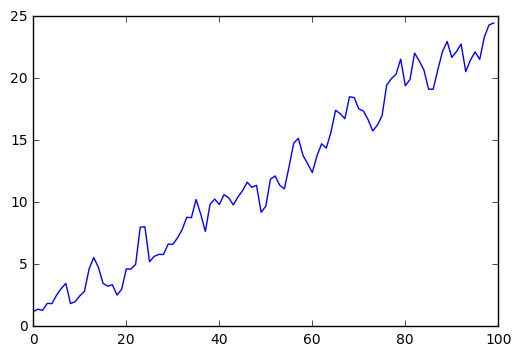

In [14]:
us = generatelatentS(N,kernel=kenrel1,scale=False)
plt.plot(us)

In [76]:



def generatelatent(N,noiselevel=0.05):
    x = np.linspace(0,N-1,N)
    u1 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=kenrel2.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    u2 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=gaussian.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g1 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=gaussian.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g2 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=Cosine1.K(x.reshape(N,1))) + noiselevel*np.random.normal(0,1,N)
    return scaleIt(u1),scaleIt(u2),scaleIt(g1),scaleIt(g2)

def generateData2(phi,P=2,S=100,C=3,N=100):
    #phi = np.random.normal(loc=0,scale=1,size=(C,P))
    phiBar = np.matrix(np.kron(phi,np.eye(N)))
    uBar = np.matrix(np.ones((S,N*P)))
    L = np.zeros(S)
    for s in range(S):
        u1,u2,g1,g2 = generatelatent(N=N)
        while u1[0] > u1[-1]: ## to make sure that we have only increasing/cyclic trend 
            u1,u2,g1,g2 = generatelatent(N=N)
        if np.random.rand() < 0.4: #Include trend lines
            uBar[s,:] = np.concatenate([u1,g1])
            L[s] = 1
        else:
            uBar[s,:] = np.concatenate([g2,g1])
            L[s] = -1
    print S,C,P,N
    YBar = uBar * phiBar.T + np.random.random()
    return YBar,L,uBar

In [77]:
N = 60
S=100
C=3
P=2
phi = np.random.normal(loc=0,scale=1,size=(C,P))
Y,L,uBar = generateData2(phi,S=S,C=C,N=N)

 /m/home/home8/81/nautiys1/unix/jupyter/venv/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning:covariance is not positive-semidefinite.


100 3 2 60


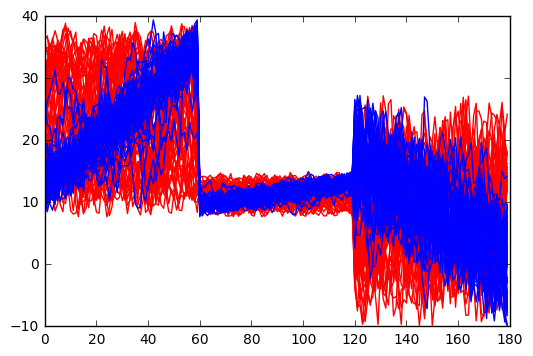

In [78]:
def plotLabel(YBar,L,S):
    for s in range(S):
        if L[s] < 0:
            plt.plot(YBar[s].T,c='r')
    for s in range(S):
        if L[s] > 0:
            plt.plot(YBar[s].T,c='b')
Y=10*Y
plotLabel(Y,L,S)

### A trial run of model on artificial data

In [79]:
import LCMGP
from sklearn.cross_validation import train_test_split
from sklearn import metrics
Y_train, Y_test, L_train, L_test = train_test_split(Y, L, test_size=0.4, random_state=0)
# fit the model
#ind=1
lcgm = LCMGP.LCMGP()
lcgm.fit(Y=Y_train,L=L_train,N=N,induction=0.9,iterations=150)
# predict for test
predictions,Expresults, _ = lcgm.predict(Y_test)


Model initialized with  0.9 induction ratio
150 updates


In [63]:
lcgm.fit(Y=Y_train,L=L_train,N=N,induction=0.9,iterations=150)
predictions,Expresults, _ = lcgm.predict(Y_test)

Model initialized with  0.9 induction ratio
150 updates


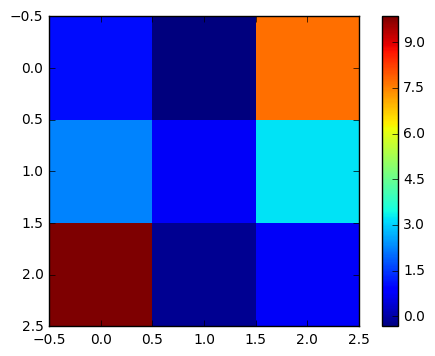

In [80]:
plt.imshow(lcgm.phiHatExp,interpolation='none')
plt.colorbar()

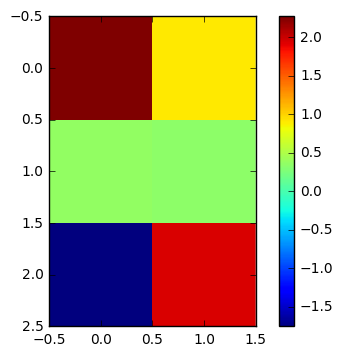

In [81]:
plt.imshow(phi,interpolation='none')
plt.colorbar()

### Checking the training projections

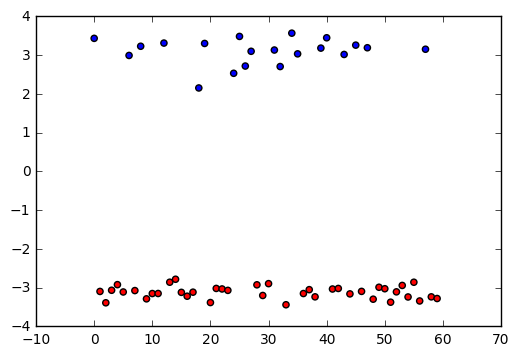

In [82]:
def getColor(L):
    if L  > 0:
        return 'b'
    else:
        return 'r'
    
plt.scatter(range(lcgm.lHatExp.shape[0]),lcgm.lHatExp,c=[getColor(l) for l in L_train])

## Checking separation for test data

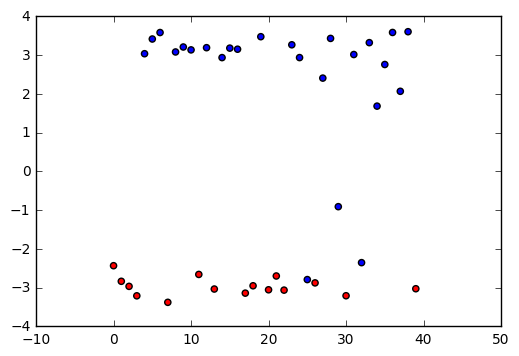

In [83]:
plt.scatter(range(Expresults.shape[0]),Expresults,c=[getColor(l) for l in L_test])

### Store data

In [85]:
import pickle
f = open("Y_linear_gaussian.pickle","wb")
pickle.dump(Y,f)
f.close()
f = open("L_linear_gaussian.pickle","wb")
pickle.dump(L,f)
f.close()
